In [144]:
import pandas as pd
import numpy as np
import random

# DataFrame Creation

In [145]:
SEED = 42 # answer to everything
# Don't really need reproducibility rn.
# np.random.seed(SEED)
# random.seed(SEED)

LABELLED_FRAC = 0.3
N_TRAIN_SAMPLES = 10000
N_SAMPLES = int(N_TRAIN_SAMPLES // LABELLED_FRAC)
print(f"Total number of samples: {N_SAMPLES}")

ID_VARIABLE_NAME = "ID" # Name of the ID variable BEFORE RENAME.
TARGET_VARIABLE_NAME = "y" # Name of the target BEFORE RENAME.

INITIAL_NOISE = 0.1
FINAL_NOISE = 0.05

CAT_ERROR_PROB = 0.1 # Probability of categorical error
LABELLED_NAN_FRAC = 0.08
UNLABELED_NAN_FRAC = 0.15

LABELLED_DUPLICATE_FRAC = 0.2 # Fraction of rows to duplicate

ARTIFICIAL_TARGET_MULTIPLIER = 1000

DATA_DIR = "data"

Total number of samples: 33333


In [146]:
class cds:
    def __init__(self, weight: int) -> None:
        self.weight = weight
        
        # Nominal
        castes = ['jut', 'kiv', 'tir', 'vel', 'qou']
        castes_p = [0.2, 0.3, 0.2, 0.2, 0.1]
        caste_col = np.random.choice(castes, N_SAMPLES, p=castes_p)

        # Ordinal
        matter = { # frequency, strength
            'corro': (6, 0),
            'corroyi': (5, 1),
            'sfer': (5, 2),
            'black corru': (3, 1),
            'corruskivi': (2, 10),
            'corrutir': (1, 10),
            'corrutir vel': (1, 12),
            'satik cyst': (5, 15),
            'pale corru': (0, 30),
        }
        matter_f_sum = sum(freq for freq, _ in matter.values())
        matter_p = [freq / matter_f_sum for freq, _ in matter.values()]
        matter_names = list(matter.keys())
        matter_col = np.random.choice(
            matter_names,
            N_SAMPLES,
            p=matter_p
        )

        # Ordinal
        mindspike_versions = {'tonga': 0, 'karbon': 1, 'silikon': 2, 'kristal': 3, 'nan': 4} # Replace 'nan' with an actual NaN later.
        mindspike_v_col = np.random.choice(
            list(mindspike_versions.keys()),
            N_SAMPLES,
            p=[0.1, 0.2, 0.2, 0.4, 0.1]
        )

        effect_matter = np.array([matter[m_name][1] for m_name in matter_col])
        effect_mindspike = np.array([mindspike_versions[m_name] for m_name in mindspike_v_col])
        y = effect_matter + effect_mindspike + np.random.normal(0, INITIAL_NOISE, N_SAMPLES)

        for i in range(N_SAMPLES):
            match caste_col[i]:
                case 'jut':
                    y[i] *= 1.5
                case 'kiv':
                    y[i] *= 0.5
                case 'tir':
                    y[i] = 0
                case 'vel':
                    y[i] = np.sin(y[i])
                case 'qou':
                    y[i] *= 3

        min_y = y.min()
        max_y = y.max()
        if min_y == max_y:
            y = np.zeros_like(y)
        else:
            y = (y - min_y) / (max_y - min_y)  # Normalize y to [0, 1]

        self.X = pd.DataFrame({
            'caste': caste_col,
            'matter': matter_col,
            'mindspike': mindspike_v_col,
        })
        self.y = pd.Series(y, name='cat_y')

        # Replace 'nan' string in mindspike with actual NaN
        self.X['mindspike'] = self.X['mindspike'].replace('nan', np.nan)

        # Induce categorical errors
        n_rows = self.X.shape[0]
        n_cat_errors = int(n_rows * CAT_ERROR_PROB)

        # Randomly choose pairs of indices
        error_row_indices = np.random.choice(self.X.index, n_cat_errors, replace=True)

        for idx in error_row_indices:
            match np.random.choice(2):
                case 0:
                    self.X.at[idx, 'caste'] = self.X.at[idx, 'caste'] + 'skin'
                case 1:
                    self.X.at[idx, 'mindspike'] = 'ERROR'

In [ ]:
from sklearn.datasets import (
    make_moons, make_circles, make_blobs, make_classification, make_hastie_10_2,
    make_friedman1, make_friedman2, make_friedman3, make_regression
)
from typing import Callable

class ds:
    def __init__(self, weight: float, name: str, generator: Callable[[], tuple[np.ndarray, np.ndarray]]):
        self.weight: float = weight
        self.name: str = name

        self.raw_X: np.ndarray
        self.raw_y: np.ndarray
        self.raw_X, self.raw_y = generator()

        min_y = self.raw_y.min()
        max_y = self.raw_y.max()
        if min_y == max_y:
            self.raw_y = np.zeros_like(self.raw_y)
        else:
            self.raw_y = (self.raw_y - min_y) / (max_y - min_y)  # Normalize y to [0, 1]

        self.X: pd.DataFrame = pd.DataFrame(
            self.raw_X,
            columns=[
                f"{self.name}_{i+1}" for i in range(self.raw_X.shape[1])
            ]
        )
        self.y: pd.Series = pd.Series(self.raw_y, name="{self.name}_y")

    
    def __hash__(self):
        return hash(self.name)

    def __eq__(self, other):
        return isinstance(other, ds) and self.name == other.name

# Make sure each has a unique name.
DATASETS: list[ds | cds] = [
    ds(4, "moon",      lambda: make_moons(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    ds(3, "circle",    lambda: make_circles(n_samples=N_SAMPLES, noise=INITIAL_NOISE, factor=0.6, random_state=SEED)),
    ds(2, "blob",      lambda: make_blobs(n_samples=N_SAMPLES, centers=3, n_features=2, random_state=SEED, return_centers=False)), # type: ignore # return_centers=False to avoid returning centers
    ds(2, "hastie",    lambda: make_hastie_10_2(n_samples=N_SAMPLES, random_state=SEED)),
    ds(2, "friedman1", lambda: make_friedman1(n_samples=N_SAMPLES, n_features=7, noise=INITIAL_NOISE, random_state=SEED)),
    ds(2, "friedman2", lambda: make_friedman2(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    ds(2, "friedman3", lambda: make_friedman3(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    cds(2),
    ds(1, "class",     lambda: make_classification(n_samples=N_SAMPLES, n_features=7, n_informative=3, n_redundant=2, n_repeated=2, n_classes=4, class_sep=0.5, flip_y=0.2, weights=[0.6, 0.2, 0.1, 0.1], random_state=SEED)),
    ds(1, "reg",       lambda: make_regression(n_samples=N_SAMPLES, n_features=5, n_informative=2, noise=INITIAL_NOISE, random_state=SEED, coef=False)), # type: ignore # coef=False to avoid returning coefficients
]

In [148]:
df = pd.concat([d.X for d in DATASETS], axis=1)
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True) # Shuffle rows, just in case.

normalized_weights = np.array([d.weight for d in DATASETS], dtype=np.float64) # dtype=np.float64 for division in the next line
normalized_weights /= normalized_weights.sum()
y_final = sum(DATASETS[i].y * normalized_weights[i] for i in range(len(DATASETS)))
y_final += np.random.normal(0, FINAL_NOISE, size= N_SAMPLES) # Some small, random noise to the final target
df[TARGET_VARIABLE_NAME] = y_final * ARTIFICIAL_TARGET_MULTIPLIER # Scale the target to a larger range for larger RMSEs

id = pd.Series(np.arange(df.shape[0]), name=ID_VARIABLE_NAME)
df[ID_VARIABLE_NAME] = id
# Making sure the ID column is the first column; makes the analysis prettier.
cols = [ID_VARIABLE_NAME] + [col for col in df.columns if col != ID_VARIABLE_NAME]
df = df[cols]

# Analysis

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

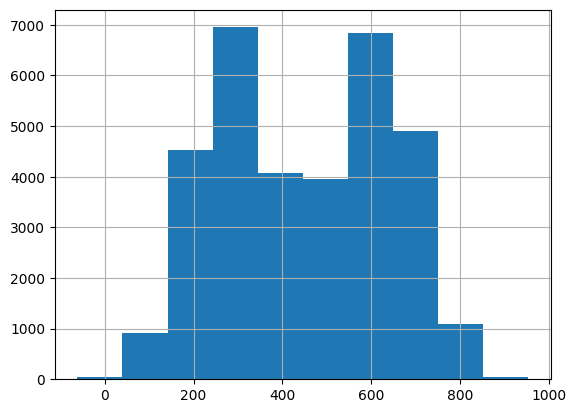

In [150]:
df[TARGET_VARIABLE_NAME].hist()

In [151]:
df.head()

,ID,moon_1,moon_2,circle_1,circle_2,blob_1,blob_2,hastie_1,hastie_2,hastie_3,...,class_4,class_5,class_6,class_7,reg_1,reg_2,reg_3,reg_4,reg_5,y
0,0,0.397852,-0.447386,-0.062957,0.409436,-5.301292,-8.805869,1.675727,0.769666,2.098498,...,0.948234,-0.665922,-0.608763,-0.723514,-1.074748,0.450164,-0.034495,-0.269409,1.161175,547.096618
1,1,-0.915294,0.215264,0.548211,-1.062733,-8.507909,-6.043312,0.995985,0.824922,0.076421,...,1.347835,-2.733897,-2.235352,0.817513,-0.027741,-1.491505,-0.293837,-1.349642,1.359401,245.507969
2,2,-0.608899,0.754366,-0.034788,-0.981595,-3.177288,10.006328,0.265400,-1.762195,0.206428,...,-0.668820,1.928017,-0.026049,1.210414,-1.236775,0.049370,0.901638,-0.920871,0.912815,168.685647
3,3,-0.984435,0.099325,1.002769,-0.114834,4.109702,0.853517,0.460416,-0.139542,0.256783,...,0.176431,0.452142,0.176619,-0.516862,-0.561253,-0.079779,-0.786803,-2.324013,-0.822813,405.294515
4,4,1.787547,-0.150399,0.165876,-0.634961,-8.054779,-8.709926,0.407200,0.514085,0.913108,...,-0.006802,-1.909636,0.096380,-0.204498,-1.357518,1.080056,-0.900671,-0.964200,0.942789,485.574579


In [152]:
# Numerical and categorical columns
num_cols = df.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

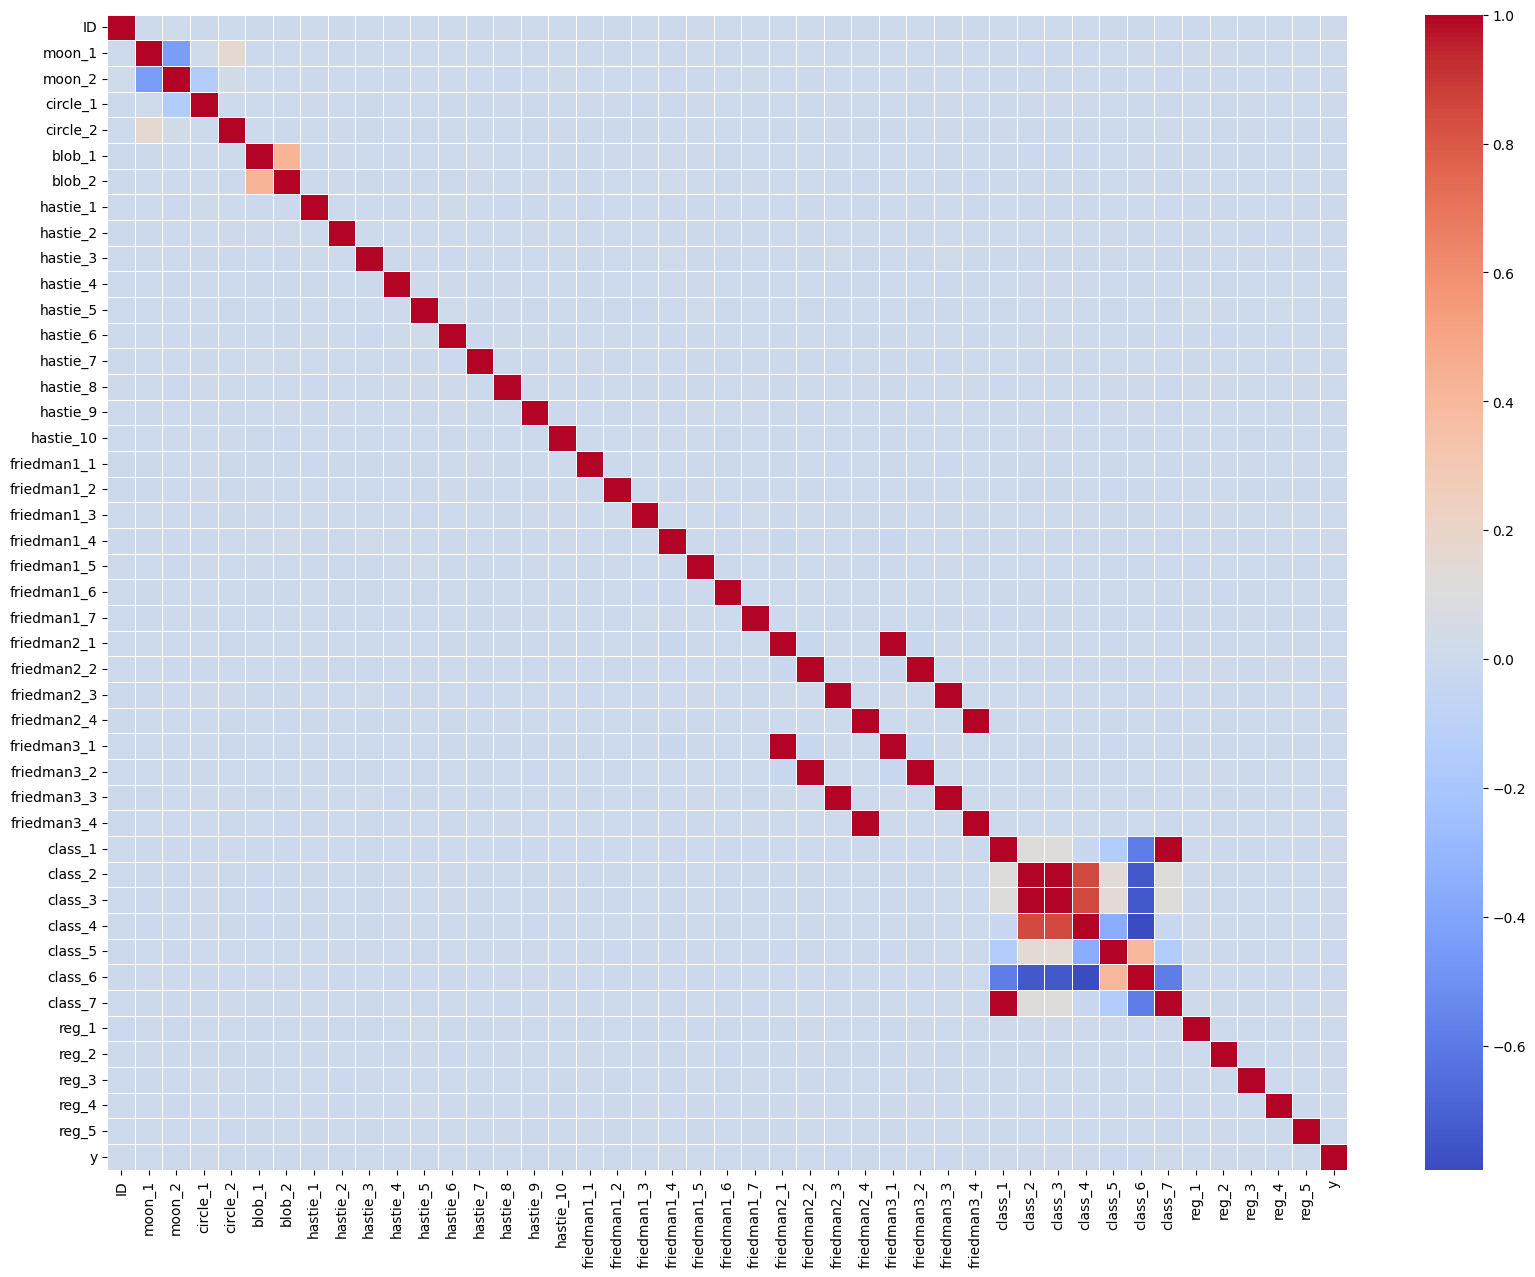

In [153]:
# Correlogram
temp = df.drop(columns=cat_cols)
correlation_matrix = temp.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.show()

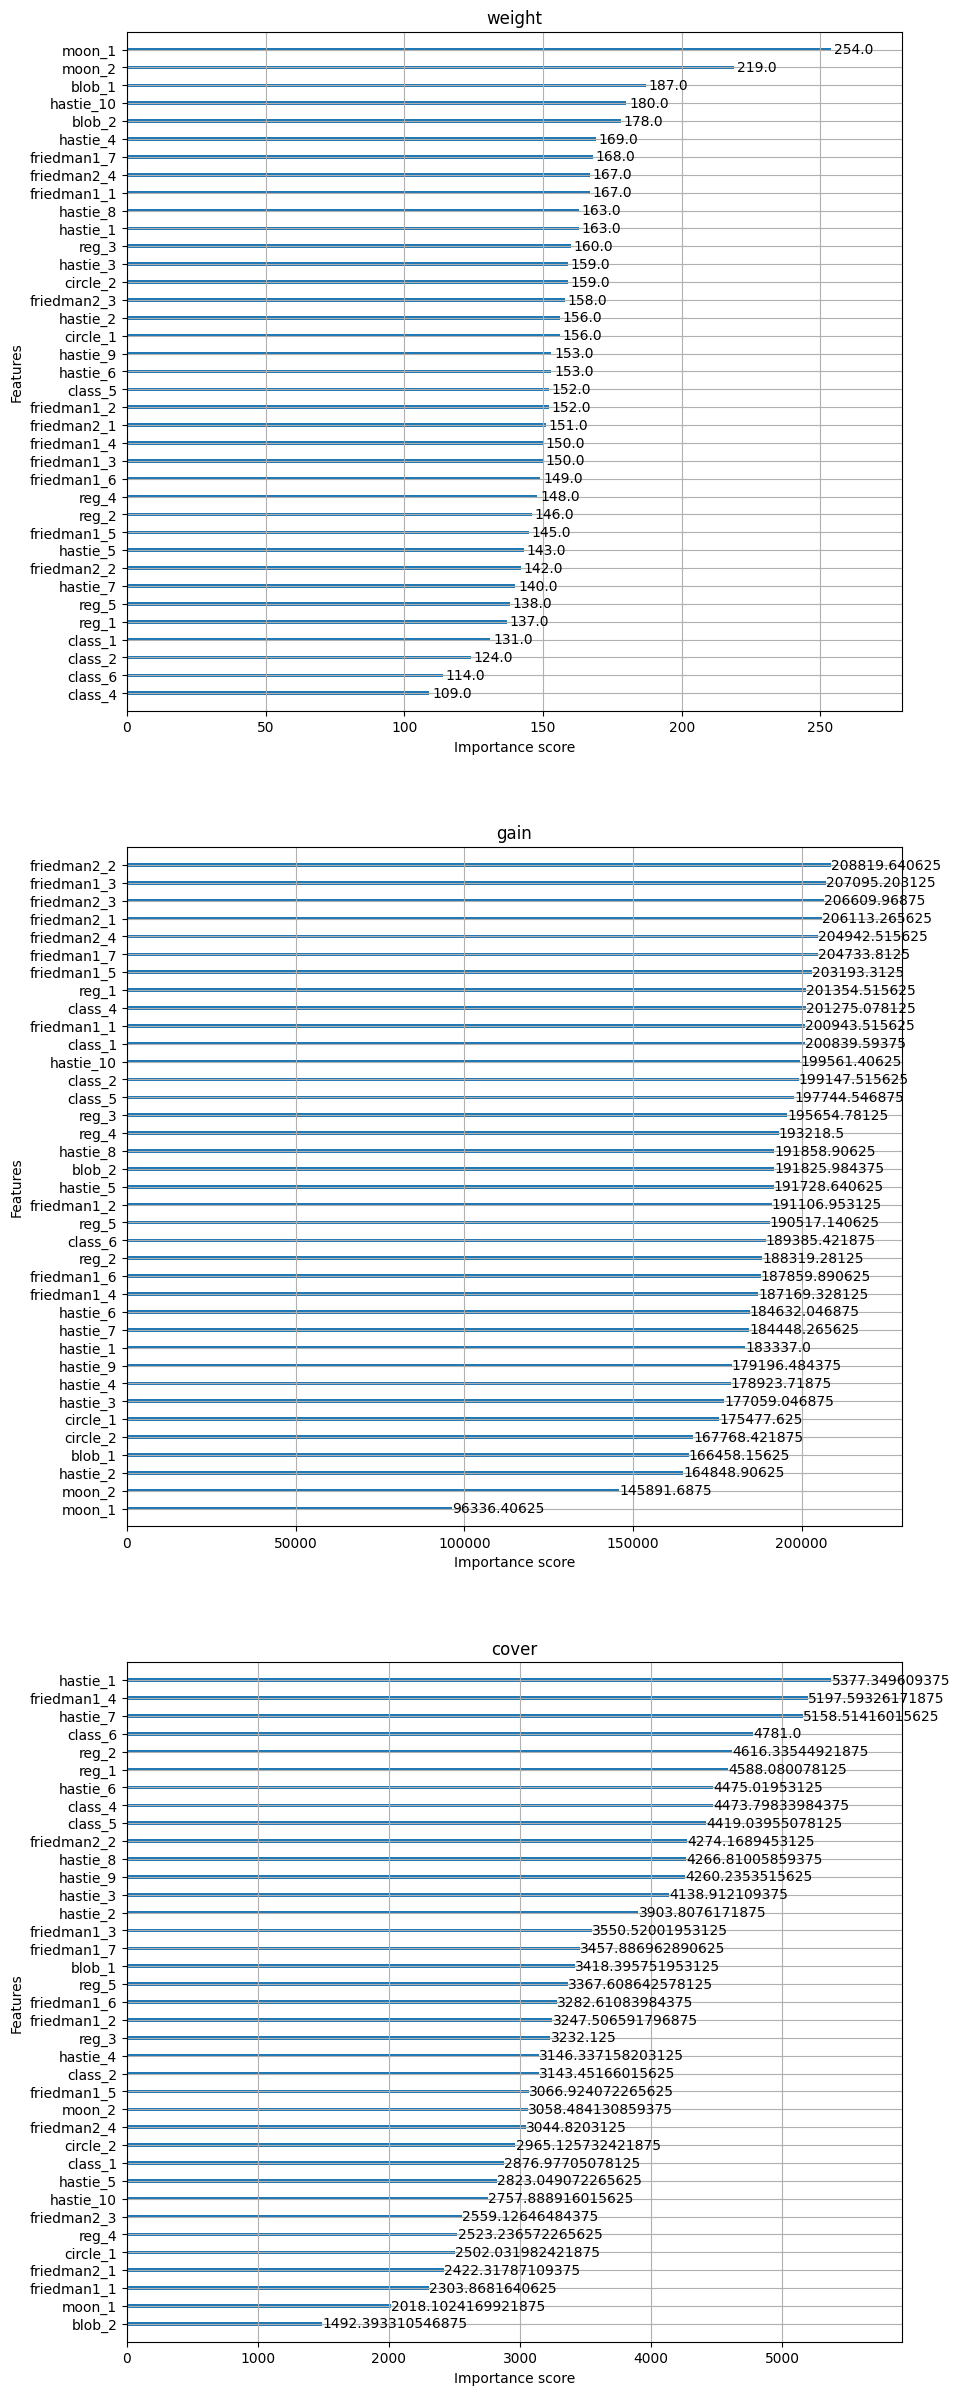

In [154]:
# xgboost feature importance
from xgboost import plot_importance, XGBRegressor

X1 = pd.DataFrame(df[num_cols].drop(columns=[TARGET_VARIABLE_NAME, ID_VARIABLE_NAME]), columns=df.columns, index=df.index)
model = XGBRegressor()
model.fit(X1, df[TARGET_VARIABLE_NAME])

fig, axs = plt.subplots(3, 1, figsize=(10, 30))
for ax, importance_type in zip(axs, ['weight', 'gain', 'cover']):
    plot_importance(model, ax=ax, importance_type = importance_type, title = importance_type)
plt.show()

# CSV Creation

In [155]:
# Column shuffling with the target column at the end and ID at the beginning
cols = df.columns.tolist()
df = df[[cols[0]] + np.random.permutation(cols[1:-1]).tolist() + [cols[-1]]]
df.columns

Index(['ID', 'friedman1_7', 'hastie_5', 'friedman3_3', 'friedman2_3', 'reg_4',
       'friedman1_6', 'reg_5', 'friedman1_3', 'class_4', 'circle_1',
       'friedman3_4', 'friedman1_2', 'circle_2', 'matter', 'hastie_6',
       'class_5', 'friedman2_4', 'friedman3_2', 'hastie_1', 'friedman3_1',
       'friedman2_2', 'caste', 'hastie_7', 'mindspike', 'reg_2', 'hastie_8',
       'hastie_3', 'class_7', 'class_3', 'hastie_2', 'class_2', 'hastie_10',
       'friedman2_1', 'friedman1_4', 'friedman1_5', 'friedman1_1', 'hastie_9',
       'moon_1', 'reg_1', 'blob_1', 'moon_2', 'hastie_4', 'reg_3', 'class_6',
       'class_1', 'blob_2', 'y'],
      dtype='object')

In [156]:
# Column renaming
renaming = {
    ID_VARIABLE_NAME: 'LOCAL_IDENTIFIER',
    TARGET_VARIABLE_NAME: 'CORRUCYSTIC_DENSITY',

    'moon_1': 'v0rt3X',
    'moon_2': 'v1rt3X',
    'circle_1': 'r1Ng',
    'circle_2': 'r2Ng',
    'blob_1': 'b1oRb13',
    'blob_2': 'b2oRb13',

    'mindspike': 'MINDSPIKE_VERSION',
    'matter': 'maT_r',
}

generic_cols = [col for col in df.columns if col not in renaming]

import string

def random_gibberish(mean_length: int = 4, std_length = 3) -> str:
    length = max(3, int(round(random.gauss(mean_length, std_length))))
    chars = string.ascii_letters + string.digits + string.punctuation
    return ''.join(random.choice(chars) for _ in range(length))

gibberish_mapping = {col: random_gibberish() for col in generic_cols}

final_mapping = {**renaming, **gibberish_mapping}

df.rename(columns=final_mapping, inplace=True)
df.columns

Index(['LOCAL_IDENTIFIER', 'Z~x0<k', 'vzo."', '+U@', 'A>.', 'hp!', '>?64:',
       '@wnsk>R', 'U"r', '&%)LTaWRb', 'r1Ng', '|G}', 'TSWm', 'r2Ng', 'maT_r',
       '@V9', 'T\!', '14W$Q', 'ZZw3=!t', '.o<m', '.b6nl', '<!!', 'F'3Ku',
       '~7*', 'MINDSPIKE_VERSION', '9Z/5)2', '%IiL7w', '!;@Jw', 'fPqsI', 'ZVf',
       'i]7V', 'Jv[i', ';<"<i(T', 'Kj,', 'w-u:jN'qI', 'PZ8', 'jNhEum', ']xq',
       'v0rt3X', '^%a;', 'b1oRb13', 'v1rt3X', '0HU2N='U', 'ZrK', '.6AvGp',
       '3I\y', 'b2oRb13', 'CORRUCYSTIC_DENSITY'],
      dtype='object')

In [157]:
labelled = df.iloc[:N_TRAIN_SAMPLES]
unlabelled = df.iloc[N_TRAIN_SAMPLES:]

In [158]:
# Add duplicate rows to the training set alone
print(f'Labeleld dataset shape before duplication: {labelled.shape}')
rows_to_duplicate = labelled.sample(frac=LABELLED_DUPLICATE_FRAC, replace=False, random_state=SEED)
labelled = pd.concat([labelled, rows_to_duplicate], ignore_index=True)
labelled = labelled.sample(frac=1) # Shuffle the training set
print(f'Labeleld dataset shape after duplication: {labelled.shape}')

Labeleld dataset shape before duplication: (10000, 48)
Labeleld dataset shape after duplication: (12000, 48)


In [159]:
# Check for duplicates
assert labelled.drop(columns=[renaming[ID_VARIABLE_NAME]]).duplicated().any()

In [160]:
# Renumber the IDs in both sets
labelled = labelled.reset_index(drop=True)
labelled[renaming[ID_VARIABLE_NAME]] = np.arange(len(labelled))

unlabelled = unlabelled.reset_index(drop=True)
unlabelled[renaming[ID_VARIABLE_NAME]] = np.arange(len(unlabelled))

In [161]:
# Populate NaNs
# WARNING: Renaming has taken place.

def add_nans(df: pd.DataFrame, prob: float, dont_add_on_target: bool = False) -> pd.DataFrame:
    rng = np.random.default_rng(SEED)
    df = df.copy()

    id_col = renaming[ID_VARIABLE_NAME]
    target_col = renaming[TARGET_VARIABLE_NAME]

    maskable_cols = [c for c in df.columns if c != id_col and not (dont_add_on_target and c == target_col)]
    n_rows = len(df)
    n_cols = len(maskable_cols)

    if n_rows == 0 or n_cols == 0 or prob <= 0:
        return df

    # Create a boolean mask for all maskable cells
    mask = rng.random((n_rows, n_cols)) < prob
    df.loc[:, maskable_cols] = df.loc[:, maskable_cols].mask(mask)

    return df

labelled = add_nans(labelled, prob=LABELLED_NAN_FRAC, dont_add_on_target=False)
unlabelled = add_nans(unlabelled, prob=UNLABELED_NAN_FRAC, dont_add_on_target=True)

In [162]:
unlabelled

,LOCAL_IDENTIFIER,Z~x0<k,"vzo.""",+U@,A>.,hp!,>?64:,@wnsk>R,"U""r",&%)LTaWRb,...,v0rt3X,^%a;,b1oRb13,v1rt3X,0HU2N='U,ZrK,.6AvGp,3I\y,b2oRb13,CORRUCYSTIC_DENSITY
0,0,0.980739,0.958386,0.004940,0.004940,NaN,0.865577,-1.367293,0.511275,NaN,...,0.476519,0.464300,-2.063554,-0.501827,1.194592,0.006870,-1.028428,-1.061418,9.635542,115.621729
1,1,0.245401,-0.566056,0.815960,NaN,1.194240,NaN,-1.930202,0.322495,-1.606526,...,0.590473,NaN,NaN,0.692642,-0.238893,0.026095,1.403662,0.701069,-5.965220,643.206774
2,2,0.182145,-0.877461,0.084529,0.084529,0.365240,NaN,NaN,0.758065,0.473402,...,0.728635,0.366504,-6.313549,0.556000,0.032132,0.703049,NaN,0.335245,-7.597224,703.076496
3,3,0.986554,NaN,0.851115,0.851115,2.872461,0.672369,-0.869342,0.570134,-0.453412,...,NaN,-1.439199,-1.323493,1.074201,-0.423674,0.694802,0.180936,0.355190,9.733239,543.477664
4,4,0.473616,-0.143185,0.138696,NaN,-2.325966,0.338070,0.068695,0.761005,NaN,...,0.645189,0.604597,-2.522695,-0.331805,-0.768607,NaN,-1.006998,0.239110,NaN,637.672545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23328,23328,0.870224,0.581433,0.101734,NaN,-0.221428,0.786717,NaN,0.587176,0.119989,...,0.927902,0.890150,-1.335297,0.449526,-0.032586,0.973809,-0.524441,0.558329,7.996248,737.470427
23329,23329,0.336404,NaN,0.741697,NaN,NaN,0.393096,1.236121,0.414296,0.024568,...,0.724041,-1.250543,4.725109,0.326703,NaN,1.105659,-0.033982,0.003898,2.813900,243.707747
23330,23330,NaN,0.513156,0.510605,0.510605,-0.699468,0.138096,NaN,NaN,0.626269,...,0.565977,-1.121040,-7.971740,0.871632,-0.544891,0.930135,-0.677822,-0.092482,-5.902496,146.999836
23331,23331,0.874766,0.613266,NaN,0.211636,2.067906,0.262695,-1.051310,0.856154,-0.182311,...,1.568515,-1.173880,4.076896,-0.501362,0.419051,-0.197938,0.814608,-0.807215,2.568011,204.385351


In [163]:
# Save the datasets to CSV files
from datetime import datetime
from os import makedirs
from shutil import rmtree
timestamp = datetime.now().strftime("%dT%H%M%S")
rmtree(DATA_DIR)  # Remove the old directory if it exists # comment out if you want to keep the old data
makedirs(f"{DATA_DIR}/{timestamp}", exist_ok=True) # Create directory if it doesn't exist

unlabelled_answers = unlabelled[[renaming[ID_VARIABLE_NAME], renaming[TARGET_VARIABLE_NAME]]].copy()
unlabelled.drop(columns=[renaming[TARGET_VARIABLE_NAME]], inplace=True)
labelled.to_csv(f"{DATA_DIR}/{timestamp}/labelled.csv", index=False)
unlabelled.to_csv(f"{DATA_DIR}/{timestamp}/unlabelled.csv", index=False)
unlabelled_answers.to_csv(f"{DATA_DIR}/{timestamp}/unlabelled_answers.csv", index=False)